# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first, merge

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [9]:
decoys = tmol.tests.data.structures_bysize()

In [10]:
from itertools import product

import tmol.score.ljlk.numba_potential

def benchmark_decoys(decoys):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 400:
            pass
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        ibd = score_graph.interblock_distance.min_dist[0]
        
        cpu_scores = {}
        
        for parallel, blocked in product((True, False), (True, False)):
            n = ".cpu" + ("_parallel" if parallel else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords,
                    types,
                    path_length,

                    ljlk_resolver.pair_params.lj_sigma,
                    ljlk_resolver.pair_params.lj_switch_slope,
                    ljlk_resolver.pair_params.lj_switch_intercept,
                    ljlk_resolver.pair_params.lj_coeff_sigma12,
                    ljlk_resolver.pair_params.lj_coeff_sigma6,
                    ljlk_resolver.pair_params.lj_spline_y0,
                    ljlk_resolver.pair_params.lj_spline_dy0,

                    ljlk_resolver.global_params.lj_switch_dis2sigma,
                    ljlk_resolver.global_params.spline_start,
                    ljlk_resolver.global_params.max_dis,
                    parallel=parallel,
                    block_distances=ibd if blocked else None
                ).sum()
            cpu_scores[n] = score
            
        logging.info(f"cpu: {cpu_scores}")
         
        
        score_graph_c = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system, device=torch.device("cuda"))
        ljlk_resolver_c = score_graph_c.param_resolver
        coords_c = score_graph_c.coords.detach()[0]
        types_c = types.cuda()
        path_length_c = path_length.cuda()
        ibd_c = score_graph_c.interblock_distance.min_dist[0]
                
        inputs = dict(
            atom_types = types_c,
            bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
         lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
         lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
         lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
         lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
         lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
         lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
         lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
            
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        cuda_scores = {}
        
        for preorg, blocked in product((True, False), (True, False)):
            n = ".cuda" + ("_preorg" if preorg else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords_c,
                    **merge(inputs, preorg_params if preorg else params),
                    block_distances=ibd_c if blocked else None
                ).sum()
            cuda_scores[n] = score
                
            
        logging.info(f"cuda_scores: {cuda_scores}")
        
    return stats

In [11]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys(decoys)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-84.5055), '.cpu_parallel': tensor(-84.5055), '.cpu_blocked': tensor(-84.5055), '.cpu': tensor(-84.5055)}
INFO:numba.cuda.cudadrv.driver:init
INFO:root:cuda_scores: {'.cuda_preorg_blocked': tensor(-84.4215, device='cuda:0'), '.cuda_preorg': tensor(-84.4215, device='cuda:0'), '.cuda_blocked': tensor(-84.4215, device='cuda:0'), '.cuda': tensor(-84.4215, device='cuda:0')}
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-9.2401), '.cpu_parallel': tensor(-9.2401), '.cpu_blocked': tensor(-9.2401), '.cpu': tensor(-9.2401)}
INFO:root:cuda_scores: {'.cuda_preorg_blocked': tensor(-11.7282, device='cuda:0'), '.cuda_preorg': tensor(-11.7282, device='cuda:0'), '.cuda_blocked': tensor(-11.7282, device='cuda:0'), '.cuda': tensor(-11.7282, device='cuda:0')}
INFO:root:BYSIZE_250

In [16]:
import pandas
import seaborn
from matplotlib import pyplot

In [17]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu_blocked'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

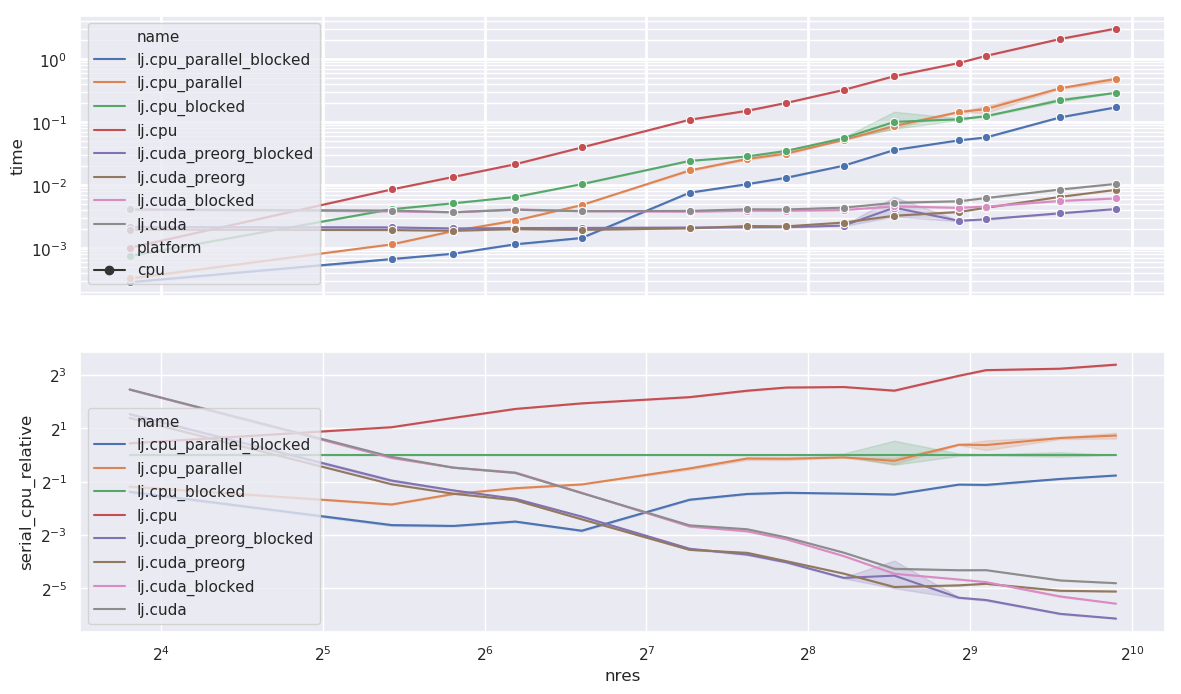

In [18]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [20]:
display(
    dat.query("name=='lj.cpu_blocked'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

display(
    dat.query("name=='lj.cuda_preorg_blocked'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14                   1.0  0.000752            3.744037  0.002815   
43                   1.0  0.004165            1.125042  0.004686   
56                   1.0  0.005173            1.146135  0.005929   
73                   1.0  0.006518            1.162552  0.007578   
97                   1.0  0.010408            1.289813  0.013425   
154                  1.0  0.024361            1.092862  0.026623   
197                  1.0  0.028611            1.121982  0.032101   
233                  1.0  0.035150            1.044788  0.036724   
298                  1.0  0.055763            1.245654  0.069462   
370                  1.0  0.101330            1.448061  0.146732   
488                  1.0  0.111262            1.171660  0.130362   
548                  1.0  0.124886            1.077502  0.134565   
753                  1.0  0.222885            1.152344  0.256840   
956                  1.0  0.293695            1.001779  0.294217   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.110812  0.000083  
43              0.019652  0.000082  
56              0.023416  0.000121  
73              0.027318  0.000178  
97              0.039837  0.000415  
154             0.016276  0.000396  
197             0.031443  0.000900  
233             0.016074  0.000565  
298             0.076481  0.004265  
370             0.388034  0.039319  
488             0.060981  0.006785  
548             0.029406  0.003672  
753             0.085451  0.019046  
956             0.001450  0.000426

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              2.890567  0.002173            4.472897  0.003363   
43              0.513771  0.002140            0.942660  0.003926   
56              0.398394  0.002061            0.605883  0.003134   
73              0.320499  0.002089            0.447294  0.002916   
97              0.201788  0.002100            0.281384  0.002929   
154             0.087498  0.002132            0.118422  0.002885   
197             0.075221  0.002152            0.128612  0.003680   
233             0.061556  0.002164            0.100287  0.003525   
298             0.041030  0.002288            0.055823  0.003113   
370             0.043493  0.004407            0.064311  0.006517   
488             0.024489  0.002725            0.030596  0.003404   
548             0.023083  0.002883            0.034154  0.004265   
753             0.016117  0.003592            0.022054  0.004916   
956             0.014261  0.004188            0.016238  0.004769   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.562762  0.000423  
43              0.122680  0.000511  
56              0.054622  0.000283  
73              0.026942  0.000176  
97              0.026218  0.000273  
154             0.010927  0.000266  
197             0.010428  0.000298  
233             0.008154  0.000287  
298             0.004978  0.000278  
370             0.018109  0.001835  
488             0.002384  0.000265  
548             0.003269  0.000408  
753             0.001561  0.000348  
956             0.000502  0.000148